In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Read the data
match = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')

# Data preprocessing
total_score_df = delivery.groupby(['match_id', 'inning']).sum()['total_runs'].reset_index()
total_score_df = total_score_df[total_score_df['inning'] == 1]
match_df = match.merge(total_score_df[['match_id', 'total_runs']], left_on='id', right_on='match_id')

teams = [
    'Sunrisers Hyderabad', 'Mumbai Indians', 'Royal Challengers Bangalore',
    'Kolkata Knight Riders', 'Kings XI Punjab', 'Chennai Super Kings',
    'Rajasthan Royals', 'Delhi Capitals'
]

match_df['team1'] = match_df['team1'].str.replace('Delhi Daredevils', 'Delhi Capitals')
match_df['team2'] = match_df['team2'].str.replace('Delhi Daredevils', 'Delhi Capitals')
match_df['team1'] = match_df['team1'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')
match_df['team2'] = match_df['team2'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')

match_df = match_df[match_df['team1'].isin(teams) & match_df['team2'].isin(teams)]
match_df = match_df[match_df['dl_applied'] == 0]
match_df = match_df[['match_id', 'city', 'winner', 'total_runs']]
delivery_df = match_df.merge(delivery, on='match_id')
delivery_df = delivery_df[delivery_df['inning'] == 2]
delivery_df['total_runs_y'] = pd.to_numeric(delivery_df['total_runs_y'], errors='coerce')
delivery_df.dropna(subset=['total_runs_y'], inplace=True)

delivery_df['current_score'] = delivery_df.groupby('match_id')['total_runs_y'].cumsum()
delivery_df['runs_left'] = delivery_df['total_runs_x'] - delivery_df['current_score']
delivery_df['balls_left'] = 126 - (delivery_df['over'] * 6 + delivery_df['ball'])
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna("0").apply(lambda x: 1 if x != "0" else 0)
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].astype('int')
delivery_df['wickets'] = 10 - delivery_df.groupby('match_id')['player_dismissed'].cumsum()

delivery_df['crr'] = (delivery_df['current_score'] * 6) / (120 - delivery_df['balls_left'])
delivery_df['rrr'] = (delivery_df['runs_left'] * 6) / delivery_df['balls_left']

delivery_df['result'] = delivery_df.apply(lambda row: 1 if row['batting_team'] == row['winner'] else 0, axis=1)

final_df = delivery_df[['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left', 'wickets', 'total_runs_x', 'crr', 'rrr', 'result']]
final_df = final_df.sample(final_df.shape[0]).dropna()
final_df = final_df[final_df['balls_left'] != 0]

X = final_df.iloc[:, :-1]
y = final_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Extract categorical columns for OneHotEncoding
categorical_cols = ['batting_team', 'bowling_team', 'city']
X_cat = X_train[categorical_cols]

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')

# Fit-transform categorical columns
X_encoded = encoder.fit_transform(X_cat)

# Convert X_encoded into a DataFrame with column names
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Combine encoded features with numerical columns
numerical_cols = ['runs_left', 'balls_left', 'wickets', 'total_runs_x', 'crr', 'rrr']
X_processed = pd.concat([X_encoded_df, X_train[numerical_cols].reset_index(drop=True)], axis=1)

# Convert column names to string to avoid TypeError during model fitting
X_processed.columns = X_processed.columns.astype(str)

# Define imputer to handle NaN values
imputer = SimpleImputer(strategy='mean')
X_processed = imputer.fit_transform(X_processed)

# Initialize Logistic Regression model
logistic_model = LogisticRegression(solver='liblinear')

# Fit the model
logistic_model.fit(X_processed, y_train)


/home/daci/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


LogisticRegression(solver='liblinear')

In [9]:
from sklearn.pipeline import Pipeline

# Define the preprocessing for categorical features
categorical_cols = ['batting_team', 'bowling_team', 'city']
numerical_cols = ['runs_left', 'balls_left', 'wickets', 'total_runs_x', 'crr', 'rrr']

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_cols),
        ('cat', OneHotEncoder(sparse=False, drop='first'), categorical_cols)
    ])

# Create the pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Fit the pipeline
pipe.fit(X_train, y_train)


/home/daci/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['runs_left', 'balls_left',
                                                   'wickets', 'total_runs_x',
                                                   'crr', 'rrr']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

In [10]:
# Predict using the pipeline
y_pred = pipe.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))

# Predict probabilities for a specific instance
print(pipe.predict_proba(X_test)[10])


Accuracy: 0.8007568855561006
[0.83729275 0.16270725]


In [11]:
def match_summary(row):
    print("Batting Team-" + row['batting_team'] + " | Bowling Team-" + row['bowling_team'] + " | Target- " + str(row['total_runs_x']))

def match_progression(x_df, match_id, pipe):
    match = x_df[x_df['match_id'] == match_id]
    match = match[(match['ball'] == 6)]
    temp_df = match[['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left', 'wickets', 'total_runs_x', 'crr', 'rrr']].dropna()
    temp_df = temp_df[temp_df['balls_left'] != 0]
    
    # Ensure the data is preprocessed correctly using the pipeline
    temp_df_processed = pipe.named_steps['preprocessor'].transform(temp_df)
    
    result = pipe.named_steps['classifier'].predict_proba(temp_df_processed)
    temp_df['lose'] = np.round(result.T[0] * 100, 1)
    temp_df['win'] = np.round(result.T[1] * 100, 1)
    temp_df['end_of_over'] = range(1, temp_df.shape[0] + 1)

    target = temp_df['total_runs_x'].values[0]
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0, target)
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)
    wickets = list(temp_df['wickets'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0, 10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]

    print("Target-", target)
    temp_df = temp_df[['end_of_over', 'runs_after_over', 'wickets_in_over', 'lose', 'win']]
    return temp_df, target

# Example usage of match_progression function
temp_df, target = match_progression(delivery_df, 74, pipe)
print(temp_df)


Target- 178
       end_of_over  runs_after_over  wickets_in_over  lose   win
10459            1                4                0  55.4  44.6
10467            2                8                0  50.2  49.8
10473            3                1                0  56.6  43.4
10479            4                7                1  68.5  31.5
10485            5               12                0  58.4  41.6
10491            6               13                0  46.2  53.8
10497            7                9                0  40.4  59.6
10505            8               15                0  26.9  73.1
10511            9                7                0  24.7  75.3
10518           10               17                0  13.5  86.5
10524           11                9                1  18.9  81.1
10530           12                9                0  15.5  84.5
10536           13                8                0  13.3  86.7
10542           14                8                0  11.4  88.6
10548        

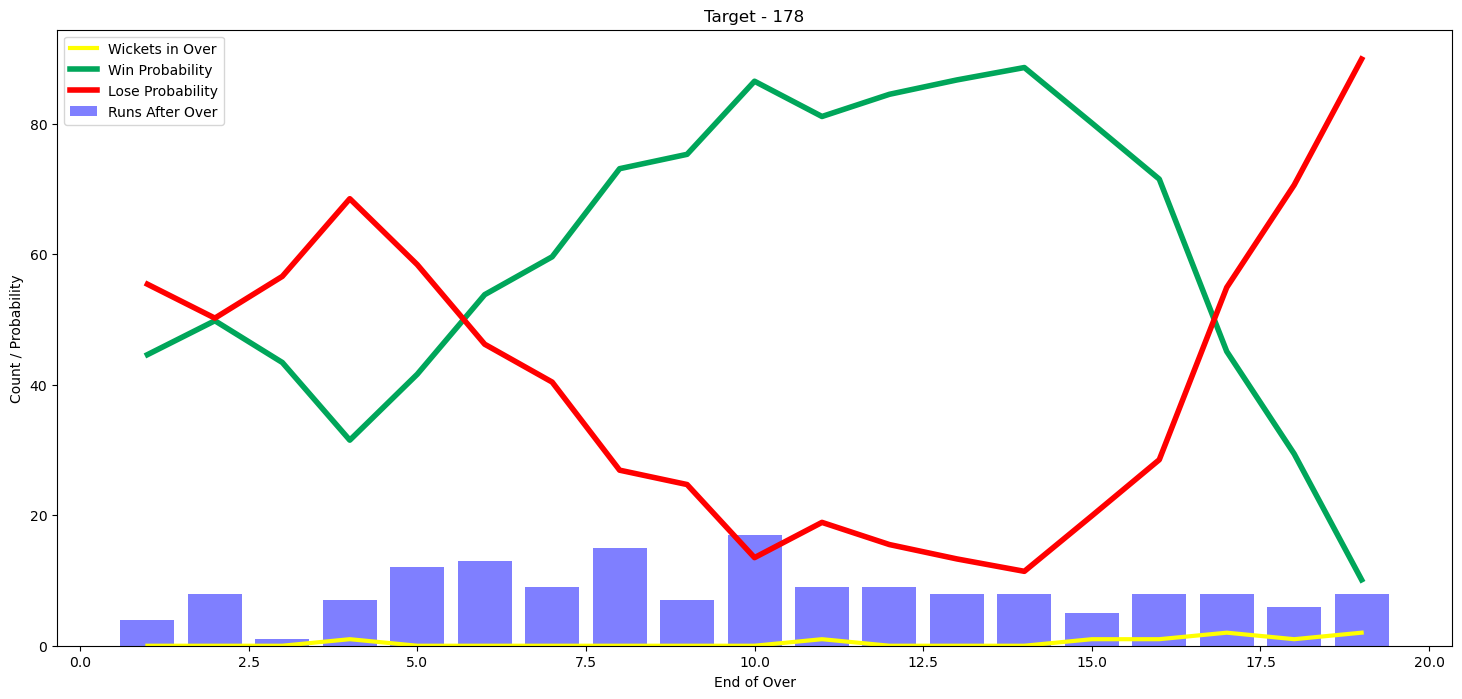

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure temp_df is a DataFrame
if isinstance(temp_df, pd.DataFrame):
    end_of_over = temp_df['end_of_over'].values
    wickets_in_over = temp_df['wickets_in_over'].values
    win = temp_df['win'].values
    lose = temp_df['lose'].values
    runs_after_over = temp_df['runs_after_over'].values

    plt.figure(figsize=(18, 8))
    plt.plot(end_of_over, wickets_in_over, color='yellow', linewidth=3, label='Wickets in Over')
    plt.plot(end_of_over, win, color='#00a65a', linewidth=4, label='Win Probability')
    plt.plot(end_of_over, lose, color='red', linewidth=4, label='Lose Probability')
    plt.bar(end_of_over, runs_after_over, color='blue', alpha=0.5, label='Runs After Over')

    plt.title(f'Target - {target}')
    plt.xlabel('End of Over')
    plt.ylabel('Count / Probability')
    plt.legend()
    plt.show()
else:
    print("temp_df is not a DataFrame")


In [14]:
delivery_df['city'].unique()

array(['Hyderabad', 'Bangalore', 'Mumbai', 'Indore', 'Kolkata', 'Delhi',
       'Chandigarh', 'Jaipur', 'Chennai', 'Cape Town', 'Port Elizabeth',
       'Durban', 'Centurion', 'East London', 'Johannesburg', 'Kimberley',
       'Bloemfontein', 'Ahmedabad', 'Cuttack', 'Nagpur', 'Dharamsala',
       'Visakhapatnam', 'Pune', 'Raipur', 'Ranchi', 'Abu Dhabi',
       'Sharjah', nan, 'Mohali', 'Bengaluru'], dtype=object)

In [15]:
teams


['Sunrisers Hyderabad',
 'Mumbai Indians',
 'Royal Challengers Bangalore',
 'Kolkata Knight Riders',
 'Kings XI Punjab',
 'Chennai Super Kings',
 'Rajasthan Royals',
 'Delhi Capitals']

In [16]:
import pickle
pickle.dump(pipe,open('pipe.pkl','wb'))